In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline # plot in cell
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

feature_names = ['mean_x', 'mean_y', 'mean_z', 
                'rms_x', 'rms_y', 'rms_z',
                'std_x', 'std_y', 'std_z',
                'var_x', 'var_y', 'var_z',
                'med_x', 'med_y', 'med_z',
                'min_x', 'min_y', 'min_z',
                'max_x', 'max_y', 'max_z',
                'pearsonr_xy', 'pearsonr_yz', 'pearsonr_zx',
                'mad_x', 'mad_y', 'mad_z']

target_names = ['Standing', 'Walking normal', 'Jumping', 
                'Sit chair', 'Stairs up', 'Stairs down', 'Jogging']
              

def featuresFromBuffer(at):
    feat = np.zeros(27)    # return array float([ 0.,  0.,  0.,  0., ....., 0.])
                            # a vector of 21 features from each window
    x = np.array(at.iloc[:,0], dtype=np.float64)   
    y = np.array(at.iloc[:,1], dtype=np.float64)   
    z = np.array(at.iloc[:,2], dtype=np.float64)  
   
    
   # Average value in signal buffer for all three acceleration components (1 each)    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means
    
    # RMS value in signal buffer for all three acceleration components (1 each)
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms
    
    # Standard deviation
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std
    
    # Variance
    var = [np.var(i) for i in [x, y, z]]
    feat[9:12] = var
    
    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[12:15] = med
    
    # Range
    Range1 = [ np.amin(i) for i in [x, y, z]]    
    feat[15:18] = Range1
    Range2 = [ np.amax(i) for i in [x, y, z]]    
    feat[18:21] = Range2
    
    # Pearsonr   
    x_pd = pd.Series(x)
    y_pd = pd.Series(y)
    z_pd = pd.Series(z)
    Pearsonr_xy = x_pd.corr(y_pd)
    feat[21] = Pearsonr_xy
    Pearsonr_yz = y_pd.corr(z_pd)
    feat[22] = Pearsonr_yz
    Pearsonr_zx = z_pd.corr(x_pd)
    feat[23] = Pearsonr_zx
    
    # Median Absolute Deviation
    mad = [stats.median_absolute_deviation(i) for i in [x, y, z]]   
    feat[24:27] = mad

    return feat  


In [2]:
# Import data

dt = pd.read_excel (r'F:\Program\OneDrive\TLNC\test.xlsx')
dt.columns
dt.shape

Index(['Jogging', 'Unnamed: 1', 'Unnamed: 2', 'Walking', 'Unnamed: 4',
       'Unnamed: 5', 'Upstairs', 'Unnamed: 7', 'Unnamed: 8', 'Downstairs',
       'Unnamed: 10', 'Unnamed: 11', 'Standing', 'Unnamed: 13', 'Unnamed: 14',
       'Sitting', 'Unnamed: 16', 'Unnamed: 17'],
      dtype='object')

(711485, 18)

In [10]:
Jogging = dt[['Jogging', 'Unnamed: 1', 'Unnamed: 2']] 
Jogging = Jogging.dropna()
Jogging.index = pd.RangeIndex(len(Jogging.index))
Jogging = Jogging.drop(0)

Walking_normal = dt[['Walking', 'Unnamed: 4', 'Unnamed: 5']] 
Walking_normal = Walking_normal.dropna()
Walking_normal.index = pd.RangeIndex(len(Walking_normal.index))
Walking_normal = Walking_normal.drop(0)

Stairs_up = dt[['Upstairs', 'Unnamed: 7', 'Unnamed: 8']] 
Stairs_up = Stairs_up.dropna()
Stairs_up.index = pd.RangeIndex(len(Stairs_up.index)) 
Stairs_up = Stairs_up.drop(0)
    
Stairs_down = dt[['Downstairs', 'Unnamed: 10', 'Unnamed: 11']] 
Stairs_down = Stairs_down.dropna()
Stairs_down.index = pd.RangeIndex(len(Stairs_down.index))
Stairs_down = Stairs_down.drop(0)

Standing = dt[['Standing', 'Unnamed: 13', 'Unnamed: 14']] 
Standing = Standing.dropna()
Standing.index = pd.RangeIndex(len(Standing.index))
Standing = Standing.drop(0)

Sitting = dt[['Sitting', 'Unnamed: 16', 'Unnamed: 17']] 
Sitting = Sitting.dropna()
Sitting.index = pd.RangeIndex(len(Sitting.index))
Sitting = Sitting.drop(0)

print (len (Jogging))
print (len (Walking_normal))
print (len (Stairs_up))
print (len (Stairs_down))
print (len(Standing))
print (len (Sitting))


Jogging

21688
35577
14441
15345
14094
15521


,Jogging,Unnamed: 1,Unnamed: 2
1,-0.694638,12.6805,0.503953
2,5.01229,11.264,0.953424
3,4.90332,10.8827,-0.0817221
4,-0.612916,18.4964,3.02372
5,-1.18497,12.1085,7.20516
...,...,...,...
21684,328982249000,5.37,-3.36
21685,0,0,0
21686,0,0,0
21687,1202262279000,-1.23,3.45


In [11]:
# Split dataset to 2 parts: Train (60%) - Test (40%)\n",

window_size = 16
stride = 6 #step
ratio = 0.6


X_jog_train = [Jogging[i:i+window_size] for i in range(0, int(len(Jogging)*ratio), stride)]
X_jog_test = [Jogging[i:i+window_size] for i in range(int(len(Jogging)*ratio), len(Jogging), stride) 
                                            if i+window_size<=len(Jogging)]

X_walk_train = [Walking_normal[i:i+window_size] for i in range(0, int(len(Walking_normal)*ratio), stride)]
X_walk_test = [Walking_normal[i:i+window_size] for i in range(int(len(Walking_normal)*ratio), len(Walking_normal),stride)
                                           if i+window_size<=len(Walking_normal)]


X_stairUp_train = [Stairs_up[i:i+window_size] for i in range(0, int(len(Stairs_up)*ratio), stride)] 
X_stairUp_test = [Stairs_up[i:i+window_size] for i in range(int(len(Stairs_up)*ratio), len(Stairs_up), stride) 
                                                if i+window_size<=len(Stairs_up)]

X_stairDown_train = [Stairs_down[i:i+window_size] for i in range(0, int(len(Stairs_down)*ratio), stride)] 
X_stairDown_test = [Stairs_down[i:i+window_size] for i in range(int(len(Stairs_down)*ratio), len(Stairs_down),      
                                                                stride) if i+window_size<=len(Stairs_down)]


X_stand_train = [Standing[i:i+window_size] for i in range(0, int(len(Standing)*ratio), stride)] 
X_stand_test = [Standing[i:i+window_size] for i in range(int(len(Standing)*ratio), len(Standing), stride) 
                                            if i+window_size<=len(Standing)]

X_sit_train = [Sitting[i:i+window_size] for i in range(0, int(len(Sitting)*ratio), stride)]
X_sit_test = [Sitting[i:i+window_size] for i in range(int(len(Sitting)*ratio), len(Sitting), stride) 
                                            if i+window_size<=len(Sitting)]

print ('X_jog_train: ', len (X_jog_train))
print ('X_jog_test: ', len (X_jog_test))

print ('X_walk_train: ', len(X_walk_train))
print ('X_walk_test: ', len(X_walk_test))

print ('X_stairUp_train: ', len (X_stairUp_train))
print ('X_stairUp_test: ', len (X_stairUp_test))

print ('X_stairDown_train: ', len (X_stairDown_train))
print ('X_stairDown_test: ', len (X_stairDown_test))

print ('X_stand_train: ', len(X_stand_train))
print ('X_stand_test: ', len(X_stand_test))

print ('X_sit_train: ', len (X_sit_train))
print ('X_sit_test: ', len (X_sit_test))

X_jog_train:  2169
X_jog_test:  1444
X_walk_train:  3558
X_walk_test:  2370
X_stairUp_train:  1444
X_stairUp_test:  961
X_stairDown_train:  1535
X_stairDown_test:  1021
X_stand_train:  1410
X_stand_test:  938
X_sit_train:  1552
X_sit_test:  1033


In [16]:
train_data = []
train_label = []

test_data = []
test_label = []

for acts in X_jog_train:
    train_data.append(acts)
    train_label.append(0)

for acts in X_walk_train:
    train_data.append(acts)
    train_label.append(1)

for acts in X_stairUp_train:
    train_data.append(acts)
    train_label.append(2)

for acts in X_stairDown_train:
    train_data.append(acts)
    train_label.append(3)

for acts in X_stand_train:
    train_data.append(acts)
    train_label.append(4)
    
for acts in X_sit_train:
    train_data.append(acts)
    train_label.append(5)


print('train-data length: ', len(train_data) )
print('train-label length: ', len(train_label) )
#print(train_label)
      
# For TEST
for acts in X_jog_test:
    test_data.append(acts)
    test_label.append(0)

for acts in X_walk_test:
    test_data.append(acts)
    test_label.append(1)
    
for acts in X_stairUp_test:
    test_data.append(acts)
    test_label.append(2)

for acts in X_stairDown_test:
    test_data.append(acts)
    test_label.append(3)
    
for acts in X_stand_test:
    test_data.append(acts)
    test_label.append(4)

for acts in X_sit_test:
    test_data.append(acts)
    test_label.append(5)

print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))

train-data length:  11668
train-label length:  11668
test-data length:  7767
test-label length:  7767


In [17]:
# Tạo mảng features 
train_features = []
test_features = []
for action in train_data:
    feat = featuresFromBuffer(action)
    train_features.append(feat)  

for action in test_data:
    feat = featuresFromBuffer(action)
    test_features.append(feat)

len(train_features)
len(test_features)

test_features


11668

7767

[array([  2.939375  ,   7.524375  ,  -1.1466631 ,  10.79386313,
         12.19109947,   4.48051854,  10.38593067,   9.59201163,
          4.33130582, 107.86755586,  92.00668711,  18.76021009,
          1.61      ,   3.91      ,  -1.09643801, -14.82      ,
         -7.5       ,  -9.724928  ,  19.46      ,  19.57      ,
          8.049625  ,   0.7119764 ,   0.12568239,   0.30573582,
          2.876244  ,   8.102409  ,   3.00883565]),
 array([ 3.73062500e+00,  6.52562500e+00, -1.53228914e+00,  1.01779839e+01,
         1.14567919e+01,  4.19272820e+00,  9.46962477e+00,  9.41670322e+00,
         3.90269903e+00,  8.96737934e+01,  8.86742996e+01,  1.52310597e+01,
         2.47500000e+00,  2.59000000e+00, -4.42661315e-01, -1.18800000e+01,
        -7.50000000e+00, -9.72492800e+00,  1.95700000e+01,  1.95700000e+01,
         6.51052600e+00,  6.54338791e-01, -5.34468889e-02,  3.83890048e-01,
         8.17653900e+00,  8.95490400e+00,  5.05847869e+00]),
 array([ 4.75875000e+00,  5.47687500e+00, -9.53

In [18]:
np.where(np.isnan(train_features))
train_features = np.nan_to_num(train_features)

np.where(np.isnan(test_features))
test_features = np.nan_to_num(test_features)

len(test_features)

(array([], dtype=int64), array([], dtype=int64))

(array([3134, 3134, 3134, 7321, 7321], dtype=int64),
 array([21, 22, 23, 22, 23], dtype=int64))

7767

In [19]:
# beginning of classification:
#https://www.kaggle.com/beagle01/prediction-with-gradient-boosting-classifier

from sklearn.feature_selection import SelectFromModel

print("Gradient Boosting Decision Tree:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100).fit(train_features, train_label)
#format: pass score in {:.3f}
print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, train_label)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, test_label)))


print("\n\nDecision Tree:") 
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree  # Nên giữ file adspy_ cùng thư mục vs các file python to use adspy_.

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, train_label)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'.format(clf2.score(train_features, train_label)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
.format(clf2.score(test_features, test_label)))


print("\n\nSVM:")
clf3 = SVC(C=100, gamma='scale').fit(train_features, train_label)
print("Accuracy on training set: {:.2f}".format(clf3.score(train_features, train_label)))
print("Accuracy on test set: {:.2f}".format(clf3.score(test_features, test_label)))


print('\n\n Random Forests: ')
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(n_estimators=200, random_state=0).fit(train_features, train_label)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf4.score(train_features, train_label)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf4.score(test_features, test_label)))


print('\n\n KNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))


Gradient Boosting Decision Tree:
Accuracy of GBDT classifier on training set: 0.963
Accuracy of GBDT classifier on test set: 0.604


Decision Tree:
Accuracy of Decision Tree classifier on training set: 0.843
Accuracy of Decision Tree classifier on test set: 0.735


SVM:
Accuracy on training set: 0.96
Accuracy on test set: 0.59


 Random Forests: 
Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.574


 KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.54


print(type(train_label[0]))
print(len(train_label))
print(type(test_features[0][0]))
print(len(train_features))

In [9]:
print('\n\n KNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


y_pred = knn.predict(test_features)
f1_score(test_label, y_pred, average='macro')
recall_score(test_label, y_pred, average='macro')
precision_score(test_label, y_pred, average='macro')

f1_score(test_label, y_pred, average='micro')
recall_score(test_label, y_pred, average='micro')
precision_score(test_label, y_pred, average='micro')



 KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.99


0.9755372839895008

0.9727572622309465

0.9785739001841821

0.9860788863109049

0.9860788863109049

0.9860788863109049

6


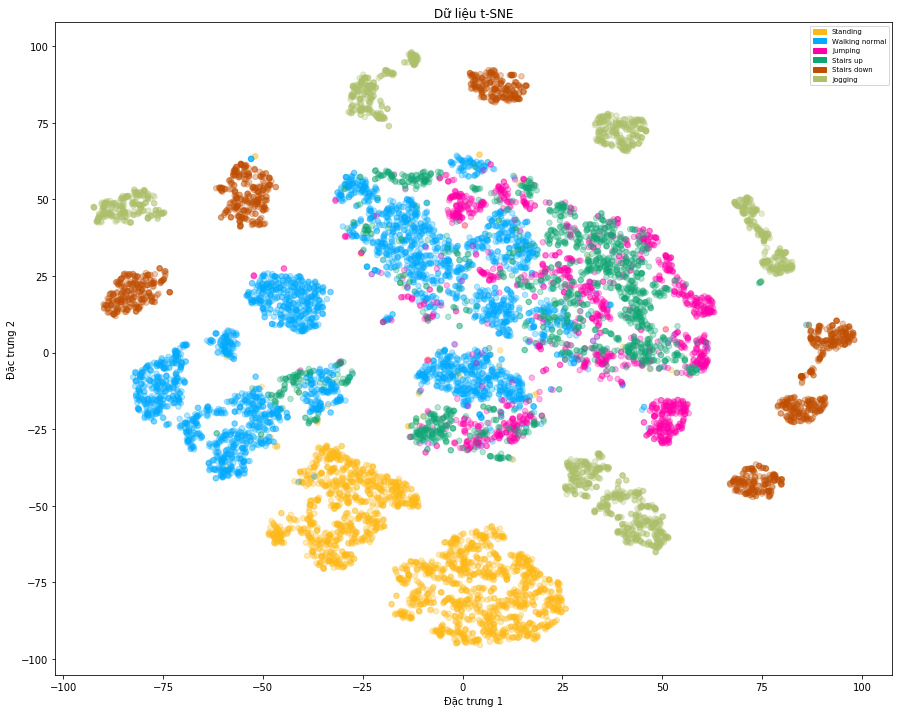

In [20]:
# t-SNE

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import graphviz 
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches


def plot_labelled_scatter(X, y, class_labels): 
    num_labels = len(class_labels)
    print(num_labels)

    # create a mesh (lưới) to plot the boundaries (đường biên)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1   # min & max for feature 1 ((column 0)) 
                    # X[row, column]
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1   # min & max for feature 2 (column 1)
    
    colors = ['#fdb915', '#00AAFF', '#FF00AA',  #'#ff0000', 
              '#10a674', '#c04e01', '#acbf69'] 
    cmap = ListedColormap(colors) 
    
   # Generate a colormap index based on discrete intervals
    norm = BoundaryNorm(numpy.arange(0, num_labels+1, 1), ncolors=num_labels) 
    
    plt.figure(figsize=(15, 12))  # độ dài row & column của 
    
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=cmap, norm=norm, alpha=0.3, lw=1)
                #edgecolor='black'
    
    # Create array h[] chứa chú thích behaviors & colors tương ứng
    h = []
    for c in range(0, num_labels):
        # tạo chú thích = mpatches.Patch
        h.append(mpatches.Patch(color=colors[c], label=class_labels[c])) 
    plt.legend(handles=h, fontsize = 'x-small') # show ghi chu
    
    plt.xlabel('Đặc trưng 1')
    plt.ylabel('Đặc trưng 2')
    plt.title('Dữ liệu t-SNE')

    plt.show()
    
X_visual = train_features
y_visual = np.array(train_label, dtype=np.uint8) 

n_samples = 300
n_components = 2  # dimension
perplexity = 30.0 # number of NEAREST NEIGHBORS that used in other MALIFOLD LEARNING algorithm (value: 5-50)
RS = 1000   

from sklearn.manifold import TSNE
# fit X_visual into embedding space in low-dimensional space and return  array (n_samples, n_components) 
X_tsne = TSNE(random_state=RS, n_components=2, perplexity=30.0, learning_rate=300.0 ).fit_transform(X_visual)
#  , n_components=2, perplexity=30.0, learning_rate=300.0             
plot_labelled_scatter(X_tsne, y_visual,['Standing','Walking normal','Jumping', 
                                        'Stairs up','Stairs down', 'Jogging'])
